In [202]:
import sys
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno


from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer

from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE

import category_encoders as ce
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
sys.setrecursionlimit(100000)

## Exploring Job Description Data

In [203]:
data_job_desc = pd.read_csv("data/job_desc.csv")
print(data_job_desc.shape)
data_job_desc.head()

(2000, 4)


,job_title_full,salary,company,user_id
0,Junior Manager Innovation Lab - France (M/F/D),51000.0,g,U1
1,Junior Product Manager - Mobile,70000.0,b,U2
2,Junior Brand Marketing Manager - Mobile (M/F/D),59000.0,g,U3
3,Product Analyst - Pricing & Forecasting (M/F/D),NaN,d,U4
4,Online Marketing Manager,64000.0,h,U5


In [204]:
data_job_desc.nunique()

job_title_full     156
salary              21
company              8
user_id           2000
dtype: int64

In [205]:
len(data_job_desc.job_title_full.unique())

156

In [206]:
data_job_desc.isnull().sum()

job_title_full       0
salary            1387
company              0
user_id              0
dtype: int64

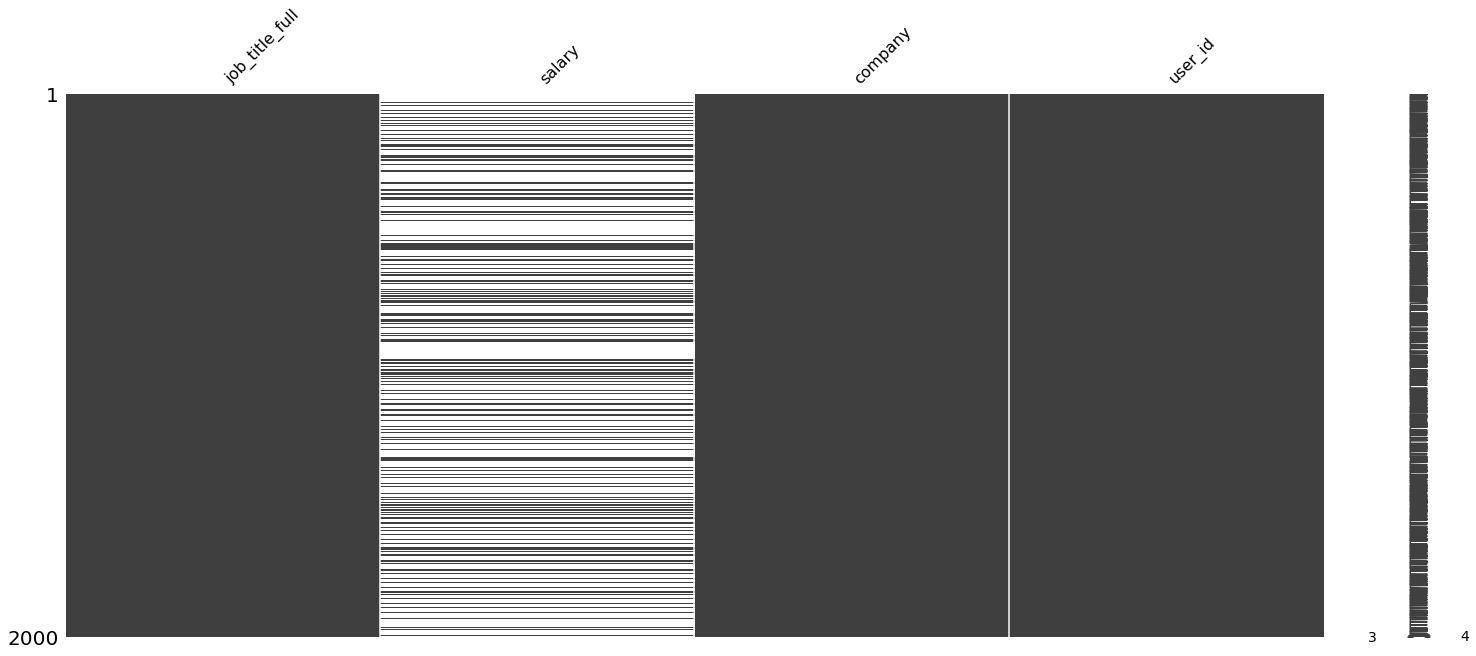

In [207]:
msno.matrix(data_job_desc)

## Exploring User Data

In [208]:
data_user = pd.read_csv("data/user.csv")
print(data_user.shape)
data_user.head()

(2000, 58)


,user_id,has_applied,v1,v10,v11,v12,v13,v14,v15,v16,...,v51,v52,v53,v54,v55,v56,v6,v7,v8,v9
0,U1,1,0.620573,0.018662,0.100803,0.080898,0.420417,0.817681,0.147355,0.446812,...,0.227104,0.811505,0.945988,0.798489,0.148969,0.707921,0.751510,0.349078,0.337132,0.807632
1,U2,1,0.972502,0.870277,0.504887,0.995163,0.179480,0.608719,0.245085,0.851246,...,0.855074,0.683701,0.318416,0.703566,0.400617,0.563469,0.989583,0.073514,0.095885,0.890821
2,U3,1,0.240756,0.546440,0.521399,0.402420,0.640444,NaN,0.184515,0.395058,...,0.614898,0.487564,0.256930,0.653874,0.761972,0.976820,0.264505,0.513135,0.978387,0.620669
3,U4,1,0.004854,0.433188,0.250801,0.242680,0.713586,0.210186,0.977472,0.375024,...,0.407412,0.242282,0.097724,0.191388,0.516972,0.742984,0.232344,0.305115,0.080069,0.297233
4,U5,1,0.835250,0.476812,0.764354,0.449753,0.524924,0.807181,0.294023,0.475043,...,0.605605,0.772735,0.351836,0.932708,0.724384,0.123647,0.091980,0.581444,0.093941,0.612623


In [209]:
data_user.user_id.nunique()

2000

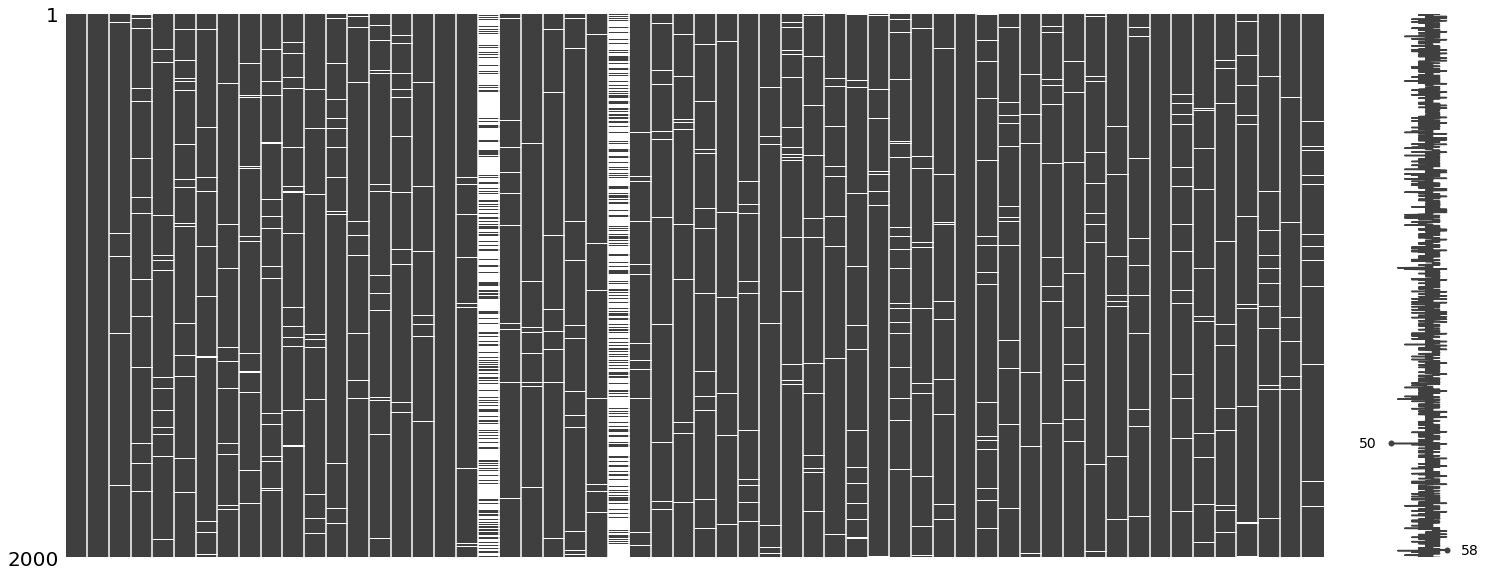

In [210]:
msno.matrix(data_user)

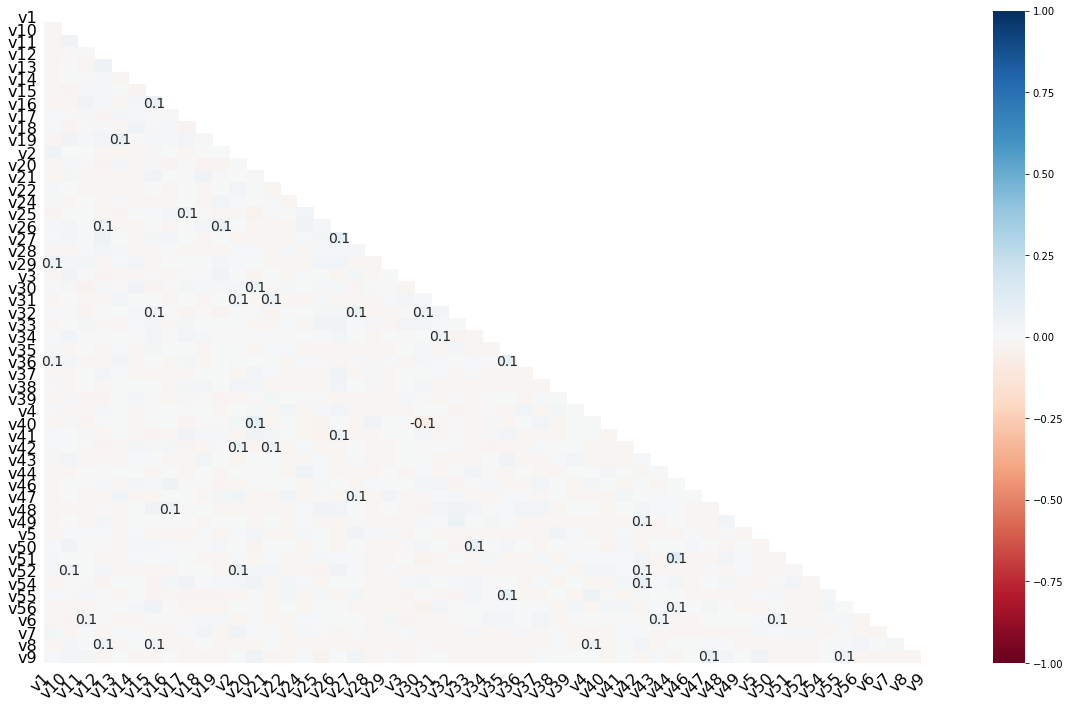

In [211]:
msno.heatmap(data_user)

## Merging & Feature Engineering (User+Job-Description) Data

In [212]:
data = pd.merge(data_job_desc, data_user, on=['user_id'])

In [213]:
data.nunique()

job_title_full     156
salary              21
company              8
user_id           2000
has_applied          2
                  ... 
v56               1959
v6                1953
v7                1973
v8                1964
v9                1960
Length: 61, dtype: int64

### Dropping User column since they are represented by Features

In [214]:
data = data.drop(['user_id'], axis=1)

### Frequency Distribution of Applied/Non-Applied, Salary and Company

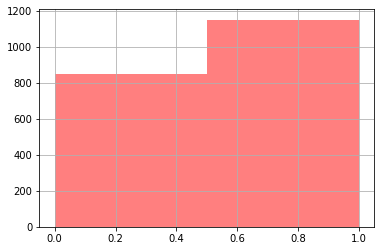

In [215]:
data['has_applied'].hist(bins=len(data.has_applied.unique()), color='red', alpha = 0.5)

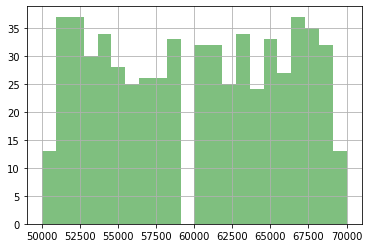

In [216]:
data['salary'].hist(bins=len(data.salary.unique()), color='green', alpha = 0.5)

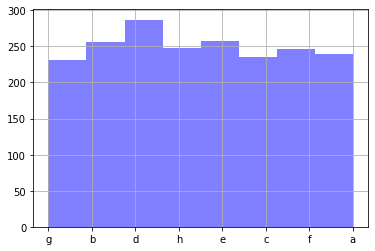

In [217]:
data['company'].hist(bins=len(data.company.unique()), color='blue', alpha = 0.5)

### Correlating Company vs Salary separately for Applied and Not-Applied Jobs.

In [218]:
pos_data = data[data['has_applied']==1]
neg_data = data[data['has_applied']==0]

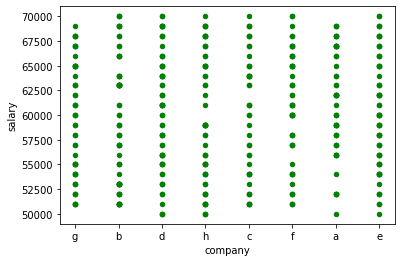

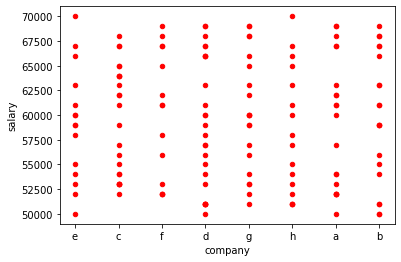

In [219]:
pos_data.plot(kind='scatter',x='company',y='salary',color='green')
neg_data.plot(kind='scatter',x='company',y='salary',color='red')

### Encode Categorical Features: Company

In [220]:
data = pd.get_dummies(data, prefix=['company'], columns =['company'])
data.columns

Index(['job_title_full', 'salary', 'has_applied', 'v1', 'v10', 'v11', 'v12',
       'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v21',
       'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v3', 'v30',
       'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v4',
       'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49',
       'v5', 'v50', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v6', 'v7', 'v8',
       'v9', 'company_a', 'company_b', 'company_c', 'company_d', 'company_e',
       'company_f', 'company_g', 'company_h'],
      dtype='object')

### Exploring Job Titles

In [221]:
def display_content(freq_map):
        
        print (top_keyword_freq_map)
        wordcloud = WordCloud(width=1800, height=1600).generate_from_frequencies(freq_map)
        plt.imshow(wordcloud)
        plt.show()
        print("Plotting top 40 contents..")
        nltk.FreqDist(freq_map).plot()

In [222]:
def get_jobtitle_keywords(jobtitle):
    manual_analysis_word_removal_list = ['(m/f/d)', 'team', '(remote)', '-']
    keywords = re.split(',| | &| ;', jobtitle)
    keywords = [word.lower() for word in keywords if
                word.lower() not in manual_analysis_word_removal_list]
    keywords = [re.sub(r'|\.|\(|\)|\]|\[|\/|-|!|\?', '', word) for word in keywords if len(word) > 1]
    keywords = list(set(' '.join(keywords).split()))
    return keywords

{'france': 132, 'junior': 517, 'innovation': 46, 'manager': 984, 'lab': 46, 'mobile': 122, 'product': 242, 'brand': 108, 'marketing': 412, 'forecasting': 80, 'pricing': 197, 'analyst': 195, 'online': 66, 'ventures': 359, 'new': 359, 'hacker': 51, 'lead': 481, 'growth': 95, 'senior': 511, 'sustainability': 54, 'data': 270, 'nlp': 130, 'owner': 46, 'learning': 149, 'engineer': 248, 'backend': 107, 'deep': 97, 'ui': 67, 'designer': 67, 'mfd': 419, 'consultant': 87, 'supplier': 85, 'financing': 85, 'seo': 153, 'operations': 43, 'researcher': 60, 'ai': 60, 'machine': 52, 'software': 82, 'developer': 99, 'scientist': 105, 'onboarding': 60, 'apac': 62, 'performance': 47, 'science': 54, 'offline': 49, 'marketeer': 58, 'business': 49, 'development': 49, 'big': 64, 'reserch': 46, 'ux': 55, 'audit': 55, 'internal': 55, 'policy': 56, 'affairs': 56, 'shop': 48, 'global': 32, 'transformation': 32, 'checkout': 36, 'frontend': 51, 'eu': 41, 'culture': 54}


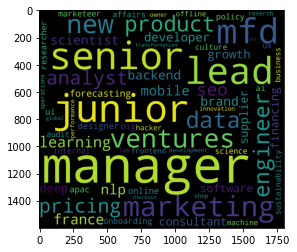

Plotting top 40 contents..


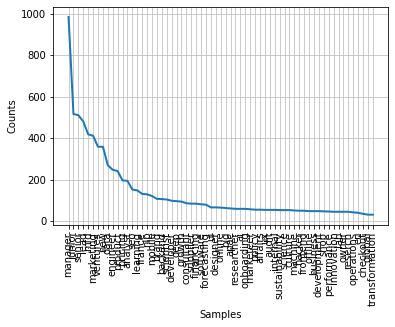

In [223]:
FEATURE_FREQUENCY_THRESHOLD = 0

keyword_freq_map = {}
for index, row in data.iterrows():
    curr_jobtitle = row['job_title_full']
    jobtitle_keywords = get_jobtitle_keywords(curr_jobtitle)

    for keyword in jobtitle_keywords:
        keyword_freq_map[keyword] = keyword_freq_map[keyword] + 1 if keyword in keyword_freq_map else 1

top_keyword_freq_map = dict((k, v) for k, v in keyword_freq_map.items() if v >= FEATURE_FREQUENCY_THRESHOLD)

display_content(top_keyword_freq_map)

In [224]:
job_keywords = list(top_keyword_freq_map.keys())

### Adding fields for Job Title Keywords

In [225]:
data['jobtitle_keywords'] = ''

for index, row in data.iterrows():
    curr_jobtitle = row['job_title_full']
    jobtitle_keywords = get_jobtitle_keywords(curr_jobtitle)
    data['jobtitle_keywords'].values[index] = jobtitle_keywords

data['jobtitle_keywords'].head()

0     [france, junior, innovation, manager, lab]
1             [mobile, product, manager, junior]
2    [mobile, junior, manager, brand, marketing]
3       [forecasting, product, pricing, analyst]
4                   [online, marketing, manager]
Name: jobtitle_keywords, dtype: object

In [226]:
mlb = MultiLabelBinarizer()
data_jobtitle_keywords_encoded = pd.DataFrame(mlb.fit_transform(data['jobtitle_keywords']),
                                              columns='jobtitle_keyword_' + mlb.classes_)
data_jobtitle_keywords_encoded.head(2)

,jobtitle_keyword_affairs,jobtitle_keyword_ai,jobtitle_keyword_analyst,jobtitle_keyword_apac,jobtitle_keyword_audit,jobtitle_keyword_backend,jobtitle_keyword_big,jobtitle_keyword_brand,jobtitle_keyword_business,jobtitle_keyword_checkout,...,jobtitle_keyword_senior,jobtitle_keyword_seo,jobtitle_keyword_shop,jobtitle_keyword_software,jobtitle_keyword_supplier,jobtitle_keyword_sustainability,jobtitle_keyword_transformation,jobtitle_keyword_ui,jobtitle_keyword_ux,jobtitle_keyword_ventures
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [227]:
data = data.drop(['jobtitle_keywords'], axis=1)
data = data.drop(['job_title_full'], axis=1)

In [228]:
data = pd.concat([data,data_jobtitle_keywords_encoded], axis = 1)
data.head()

,salary,has_applied,v1,v10,v11,v12,v13,v14,v15,v16,...,jobtitle_keyword_senior,jobtitle_keyword_seo,jobtitle_keyword_shop,jobtitle_keyword_software,jobtitle_keyword_supplier,jobtitle_keyword_sustainability,jobtitle_keyword_transformation,jobtitle_keyword_ui,jobtitle_keyword_ux,jobtitle_keyword_ventures
0,51000.0,1,0.620573,0.018662,0.100803,0.080898,0.420417,0.817681,0.147355,0.446812,...,0,0,0,0,0,0,0,0,0,0
1,70000.0,1,0.972502,0.870277,0.504887,0.995163,0.179480,0.608719,0.245085,0.851246,...,0,0,0,0,0,0,0,0,0,0
2,59000.0,1,0.240756,0.546440,0.521399,0.402420,0.640444,NaN,0.184515,0.395058,...,0,0,0,0,0,0,0,0,0,0
3,NaN,1,0.004854,0.433188,0.250801,0.242680,0.713586,0.210186,0.977472,0.375024,...,0,0,0,0,0,0,0,0,0,0
4,64000.0,1,0.835250,0.476812,0.764354,0.449753,0.524924,0.807181,0.294023,0.475043,...,0,0,0,0,0,0,0,0,0,0


### Filling in NaN values in Salary and Features Columns

In [229]:
data.isnull().sum()

salary                             1387
has_applied                           0
v1                                   27
v10                                  46
v11                                  48
                                   ... 
jobtitle_keyword_sustainability       0
jobtitle_keyword_transformation       0
jobtitle_keyword_ui                   0
jobtitle_keyword_ux                   0
jobtitle_keyword_ventures             0
Length: 129, dtype: int64

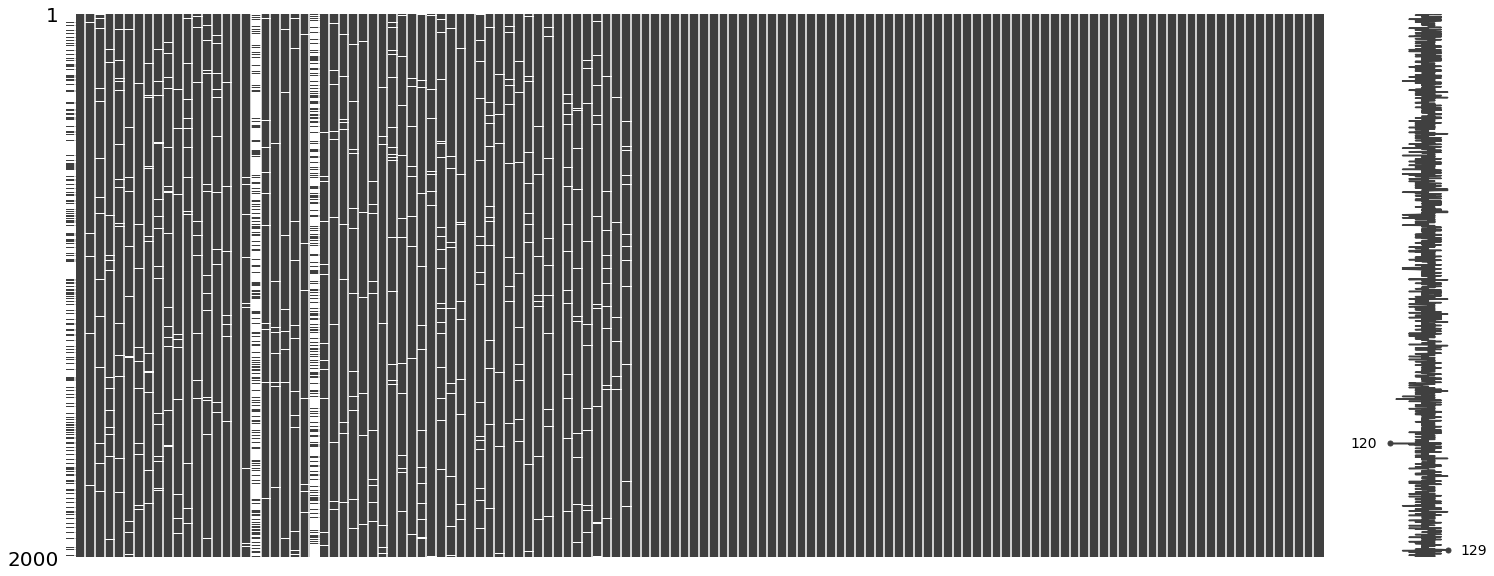

In [230]:
msno.matrix(data)

In [231]:
non_imput_cols = ['has_applied']
data_to_imput = data.drop(non_imput_cols, axis=1)
imput_cols = list(data_to_imput)
non_imputed_data = data.drop(imput_cols, axis=1) 

In [232]:
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(data_to_imput)

imp_mean_knn = KNNImputer(n_neighbors=30)

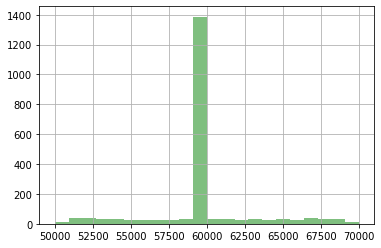

In [233]:
imputed_data = pd.DataFrame(imp_mean.transform(data_to_imput), 
                            columns = imput_cols)

imputed_data['salary'].hist(bins=len(imputed_data.salary.unique()), color='green', alpha = 0.5)

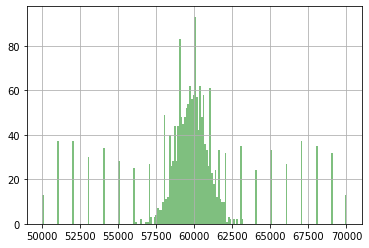

In [234]:
imputed_data = pd.DataFrame(imp_mean_knn.fit_transform(data_to_imput), 
                            columns = imput_cols)

imputed_data['salary'].hist(bins=len(imputed_data.salary.unique()), color='green', alpha = 0.5)

In [235]:
data = pd.concat([non_imputed_data, imputed_data], axis=1, join='inner')
data.head(2)

,has_applied,salary,v1,v10,v11,v12,v13,v14,v15,v16,...,jobtitle_keyword_senior,jobtitle_keyword_seo,jobtitle_keyword_shop,jobtitle_keyword_software,jobtitle_keyword_supplier,jobtitle_keyword_sustainability,jobtitle_keyword_transformation,jobtitle_keyword_ui,jobtitle_keyword_ux,jobtitle_keyword_ventures
0,1,51000.0,0.620573,0.018662,0.100803,0.080898,0.420417,0.817681,0.147355,0.446812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,70000.0,0.972502,0.870277,0.504887,0.995163,0.179480,0.608719,0.245085,0.851246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


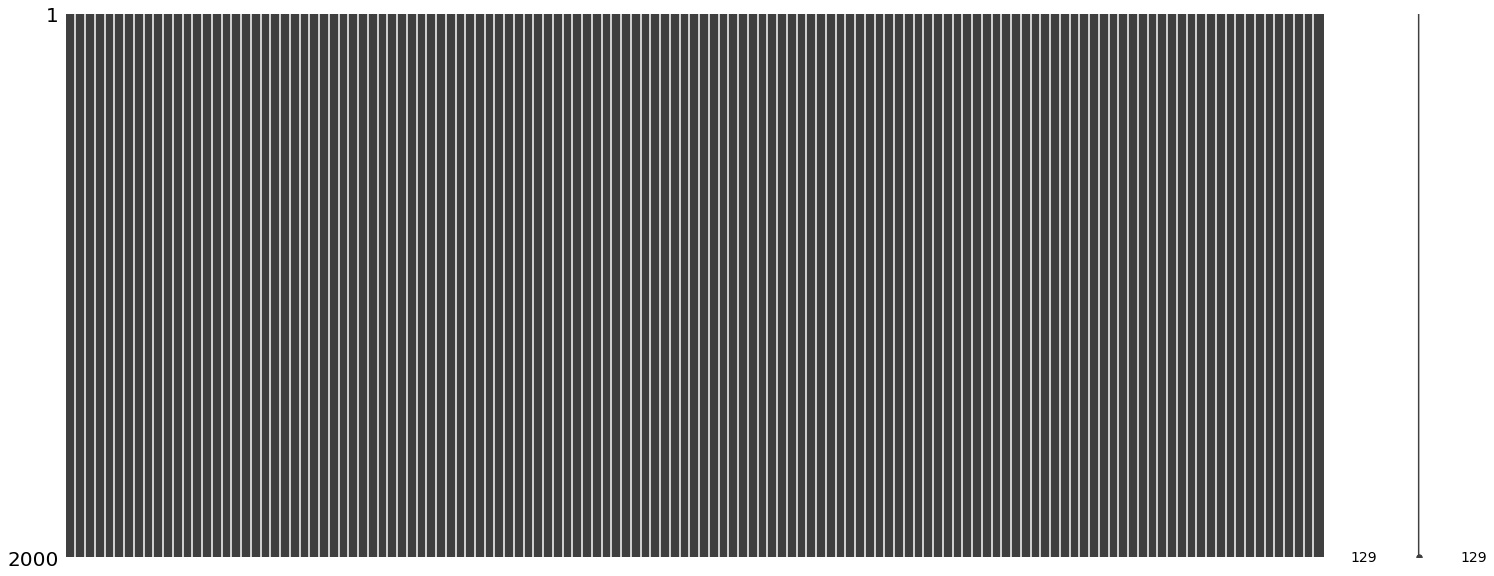

In [236]:
msno.matrix(data)

In [237]:
processed_data = data

### Training Models

In [238]:
pred_col = processed_data.has_applied
train_features = processed_data.loc[:, processed_data.columns != 'has_applied']
X_train, X_test, Y_train, Y_test = train_test_split(train_features, 
                                                    pred_col, 
                                                    test_size=0.20, 
                                                    stratify = pred_col)

In [239]:
#sampler = SMOTE()
#X_train, Y_train = sampler.fit_resample(X_train, Y_train)

In [240]:
# Rescaling numeric attributes so they have a mean of 0 and standard deviation of 1.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [241]:
def get_scores(y_pred):
    
    # TODO: Use Cross-validation to further measure scores during training
    accuracy = round(accuracy_score(Y_test, y_pred)*100,3)
    precision = round(precision_score(Y_test, y_pred)*100,3)
    recall = round(recall_score(Y_test, y_pred)*100,3)
    f1 = round(f1_score(Y_test, y_pred)*100,3)
    auroc = round(roc_auc_score(Y_test, y_pred)*100,3)

    scores = {
              "accuracy": accuracy,
              "precision": precision,
              "recall": recall,
              "f1": f1,
              "auroc": auroc
    }

    return scores

In [242]:
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X_train, Y_train)
y_pred = lr_model.predict(X_test)
lr_score = get_scores(y_pred)
print(lr_score)

{'accuracy': 50.25, 'precision': 58.47, 'recall': 46.522, 'f1': 51.816, 'auroc': 50.908}


In [243]:
svm_model = SVC(gamma='auto')
svm_model.fit(X_train, Y_train)
y_pred = svm_model.predict(X_test)
svm_score = get_scores(y_pred)
print(svm_score)

{'accuracy': 58.0, 'precision': 60.131, 'recall': 80.0, 'f1': 68.657, 'auroc': 54.118}


In [244]:
knn_model = KNeighborsClassifier(n_neighbors=6)
knn_model.fit(X_train, Y_train)
y_pred = knn_model.predict(X_test)
knn_score = get_scores(y_pred)
print(knn_score)

{'accuracy': 51.0, 'precision': 59.659, 'recall': 45.652, 'f1': 51.724, 'auroc': 51.944}


In [245]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, Y_train)
y_pred = gnb_model.predict(X_test)
gnb_score = get_scores(y_pred)
print(gnb_score)

{'accuracy': 54.0, 'precision': 63.855, 'recall': 46.087, 'f1': 53.535, 'auroc': 55.396}


In [246]:
ab_model = AdaBoostClassifier(n_estimators=70)
ab_model.fit(X_train, Y_train)
y_pred = ab_model.predict(X_test)
ab_score = get_scores(y_pred)
print(ab_score)

{'accuracy': 64.0, 'precision': 68.22, 'recall': 70.0, 'f1': 69.099, 'auroc': 62.941}


In [247]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, Y_train)
y_pred = rf_model.predict(X_test)
rf_score = get_scores(y_pred)
print(rf_score)

{'accuracy': 62.0, 'precision': 62.745, 'recall': 83.478, 'f1': 71.642, 'auroc': 58.21}


In [248]:
mlp_model = MLPClassifier(activation='relu')
mlp_model.fit(X_train, Y_train)
y_pred = mlp_model.predict(X_test)
mlp_score = get_scores(y_pred)
print(mlp_score)

{'accuracy': 55.25, 'precision': 60.759, 'recall': 62.609, 'f1': 61.67, 'auroc': 53.951}


In [249]:
et_model = ExtraTreesClassifier()
et_model.fit(X_train, Y_train)
y_pred = et_model.predict(X_test)
et_score = get_scores(y_pred)
print(et_score)

{'accuracy': 61.5, 'precision': 62.338, 'recall': 83.478, 'f1': 71.375, 'auroc': 57.621}


In [250]:
lgb_train_data = lgb.Dataset(X_train, label= Y_train)

params = {}
params['learning_rate']= 0.003
params['boosting_type']='gbdt'
params['objective']='binary'
params['metric']='binary_logloss'
params['sub_feature']=0.5
params['num_leaves']= 10
params['min_data']=50
params['max_depth']=10

lgb_model= lgb.train(params, lgb_train_data, 10000)

y_pred = lgb_model.predict(X_test)

for i in range(0,len(y_pred)):
    y_pred[i] = 1 if y_pred[i] >= 0.5 else 0 

lgb_score = get_scores(y_pred)
print(lgb_score)

{'accuracy': 67.75, 'precision': 70.782, 'recall': 74.783, 'f1': 72.727, 'auroc': 66.509}


In [251]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf_model_random = RandomizedSearchCV(estimator = rf_model, 
                                     param_distributions = random_grid, 
                                     n_iter = 30, 
                                     cv = 3, 
                                     verbose=2,
                                     random_state=42, 
                                     n_jobs = -1)
rf_model_random.fit(X_train, Y_train)

y_pred = rf_model_random.predict(X_test)
rf_random_score = get_scores(y_pred)
print(rf_random_score)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


{'accuracy': 68.5, 'precision': 69.259, 'recall': 81.304, 'f1': 74.8, 'auroc': 66.24}


In [252]:
model_names = ['Logistic Regression', 
               'Support Vector Machine', 
               'K-Nearest Neighbour', 
               'Naive Bayes', 
               'AdaBoost', 
               'LightGBM',
               'Random Forest', 
               'Random Forest (Randomized HP)', 
               'Extra-tree Classifier',
               'Multi-layer perceptron']

In [253]:
model_auroc = [lr_score['auroc'], svm_score['auroc'], knn_score['auroc'], gnb_score['auroc'], ab_score['auroc'],lgb_score['auroc'], rf_score['auroc'], rf_random_score['auroc'], et_score['auroc'], mlp_score['auroc']]

In [254]:
model_accuracy = [lr_score['accuracy'], svm_score['accuracy'], knn_score['accuracy'], gnb_score['accuracy'], ab_score['accuracy'],lgb_score['accuracy'], rf_score['accuracy'], rf_random_score['accuracy'], et_score['accuracy'], mlp_score['accuracy']]
model_precision = [lr_score['precision'], svm_score['precision'], knn_score['precision'], gnb_score['precision'], ab_score['precision'],lgb_score['precision'], rf_score['precision'], rf_random_score['precision'], et_score['precision'], mlp_score['precision']]
model_recall = [lr_score['recall'], svm_score['recall'], knn_score['recall'], gnb_score['recall'], ab_score['recall'],lgb_score['recall'], rf_score['recall'], rf_random_score['recall'], et_score['recall'], mlp_score['recall']]
model_f1 = [lr_score['f1'], svm_score['f1'], knn_score['f1'], gnb_score['f1'], ab_score['f1'],lgb_score['f1'], rf_score['f1'], rf_random_score['f1'], et_score['f1'], mlp_score['f1']]

In [255]:
model_score_df = pd.DataFrame({'auroc': model_auroc,
                               'accuracy': model_accuracy, 
                              'precision': model_precision,
                              'recall': model_recall,
                              'f1-score': model_f1},
                              index=model_names).sort_values(by=['auroc'], ascending=False)
model_score_df.head(10)

,auroc,accuracy,precision,recall,f1-score
LightGBM,66.509,67.75,70.782,74.783,72.727
Random Forest (Randomized HP),66.240,68.50,69.259,81.304,74.800
AdaBoost,62.941,64.00,68.220,70.000,69.099
Random Forest,58.210,62.00,62.745,83.478,71.642
Extra-tree Classifier,57.621,61.50,62.338,83.478,71.375
Naive Bayes,55.396,54.00,63.855,46.087,53.535
Support Vector Machine,54.118,58.00,60.131,80.000,68.657
Multi-layer perceptron,53.951,55.25,60.759,62.609,61.670
K-Nearest Neighbour,51.944,51.00,59.659,45.652,51.724
Logistic Regression,50.908,50.25,58.470,46.522,51.816


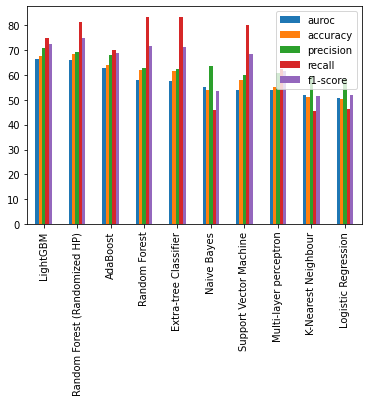

In [256]:
ax = model_score_df.plot.bar()

### Feature Importance

In [311]:
train_features.columns

Index(['salary', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17',
       ...
       'jobtitle_keyword_senior', 'jobtitle_keyword_seo',
       'jobtitle_keyword_shop', 'jobtitle_keyword_software',
       'jobtitle_keyword_supplier', 'jobtitle_keyword_sustainability',
       'jobtitle_keyword_transformation', 'jobtitle_keyword_ui',
       'jobtitle_keyword_ux', 'jobtitle_keyword_ventures'],
      dtype='object', length=128)

In [327]:
#importances = lgb_model.feature_importance()/100000
importances = rf_model.feature_importances_

In [328]:
feature_imp = {
  "salary": 0,
  "user_features": 0,
  "company": 0,
  "job_title": 0
}

for i in range(len(importances)):
    if i == 0:
        feature_imp['salary'] = importances[i]
    if i>=1 and i<=56:
        feature_imp['user_features'] = feature_imp['user_features'] + importances[i]
    if i>=57 and i<=64:
        feature_imp['company'] = feature_imp['company'] + importances[i]
    if i>=65 and i<=127:
        feature_imp['job_title'] = feature_imp['job_title'] + importances[i]

In [329]:
feature_importance = sorted(feature_imp.items())
feature_importance.sort(key = lambda x: x[1], reverse = True)  
x, y = zip(* feature_importance)

feature_importance_df = pd.DataFrame({'features': x, 'importance': y}) 
for i, row in feature_importance_df.iterrows():
    rounded_value = round(feature_importance_df.at[i,'importance']*100,3)
    feature_importance_df.at[i,'importance'] = rounded_value

feature_importance_df.head()

,features,importance
0,user_features,89.154
1,job_title,6.711
2,salary,2.981
3,company,1.154
